# File Setup

In [436]:
import os
print(os.listdir())
directory_path = ''

#from google.colab import drive
#import sys
#drive.mount('/content/drive')
#directory_path = '/content/drive/MyDrive/Quantum/'
#sys.path.append('/content/drive/MyDrive/Quantum')
# print(os.listdir(directory_path))

['dense_small.param', '.DS_Store', 'quantum_experiments', 'DiscreteVariationalParameterizationsDeepV2.py', 'Mutual_Information_Transformer.ipynb', '__pycache__', 'DiscreteVariationalParameterizationsDeepV3.py', 'README.md', 'Mutual_Information_Maximizing_Model.ipynb', 'temp.txt', '.ipynb_checkpoints', '.git', 'QuantumSimulatorDataset.py', 'GibbsSampling.py', 'Mutual_Information_VAETransformer.ipynb', '.idea']


In [437]:
!pip install torch
!pip install torchmetrics
!pip install qiskit-aer
!pip install qiskit
!pip install pylatexenc
!pip install tqdm
!pip install scikit-learn

In [439]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import ast
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.clustering import MutualInfoScore
from sklearn.metrics import mutual_info_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from QuantumSimulatorDataset import QuantumSimulationDatasetFast, generate_circuit_params
from sklearn.model_selection import train_test_split

# MI and Entropy

In [440]:
def entropy(X):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    
    # Count the occurrences of each unique value
    unique_vals, counts = X_flat.unique(return_counts=True)
    probabilities = counts.float() / counts.sum()
    entropy = -torch.sum(probabilities * torch.log(probabilities))
        
    return entropy.item()

def mutual_info_loss(X, Y):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    Y_flat = Y.view(-1)
    
    return -mutual_info_score(X_flat, Y_flat)

class MutualInformationLoss(nn.Module):
    def forward(self, input, target):
        X_flat = input.view(-1)
        Y_flat = target.view(-1)
        
        # Compute mutual information
        mi = mutual_info_score(X_flat, Y_flat)
    
        # Convert mutual information to a tensor and return the negative as loss
        mi_tensor = torch.tensor(mi, dtype=torch.float32, requires_grad=True).to(input.device)
        return -mi_tensor
    
def calc_binary_accuracy(predictions, targets):
    correct = (predictions == targets).float().sum()
    accuracy = correct / targets.numel()
    return accuracy.item()
    

# Model Definition

In [462]:
class QuantumTransformer(nn.Module):
    def __init__(
            self,
            num_qbits,
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            device,
            num_ones
    ):
        super(QuantumTransformer, self).__init__()
        self.src_emb = nn.Embedding(2, embedding_size)
        self.src_position_emb = nn.Embedding(num_qbits, embedding_size)
        self.tgt_emb = nn.Embedding(2, embedding_size)
        self.tgt_position_emb = nn.Embedding(num_qbits, embedding_size)
        self.device = device
        self.num_ones = num_ones
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout
        )
        self.fc_out = nn.Linear(embedding_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        
    def create_mask(self, size):
        mask = torch.tril(torch.ones(size, size)).to(self.device)
        return mask
    
    def forward(self, src, tgt):
        batch_size, input_dim = src.shape
        batch_size, output_dim = tgt.shape
        
        src_positions = torch.arange(0, input_dim).unsqueeze(0).expand(batch_size, input_dim).to(self.device)
        tgt_positions = torch.arange(0, output_dim).unsqueeze(0).expand(batch_size, output_dim).to(self.device)
        
        embed_src = self.dropout(self.src_emb(src) + self.src_position_emb(src_positions))
        embed_tgt = self.dropout(self.tgt_emb(tgt) + self.tgt_position_emb(tgt_positions))
        
        src_mask = self.create_mask(input_dim)
        tgt_mask = self.create_mask(output_dim)
        
        out = self.transformer(
            embed_src.permute(1, 0, 2),  # (S, N, E)
            embed_tgt.permute(1, 0, 2),  # (T, N, E)
            src_mask=src_mask,
            tgt_mask = tgt_mask
        )
        out = self.fc_out(out.permute(1, 0, 2))
        out = self.sigmoid(out) # (N, S, 1)
        
        return out.squeeze(-1) # (N, S)
    
    # Issue: predicting S-1 length sequence may not have num_ones amount of ones
    def conservation_ones_process(self, probabilities):
        sorted_indices = torch.argsort(probabilities, dim=1, descending=True)
        threshold_output = torch.zeros_like(probabilities)
    
        for j in range(probabilities.size(0)):
            threshold_output[j, sorted_indices[j, : self.num_ones]] = 1
        
        return threshold_output
    
    def predict(self, src):
        batch_size, dim = src.shape
        src_positions = torch.arange(0, dim).unsqueeze(0).expand(batch_size, dim).to(self.device)
        
        # Encode the source sequence
        embed_src = self.dropout(self.src_emb(src) + self.src_position_emb(src_positions))
        memory = self.transformer.encoder(embed_src.permute(1, 0, 2))  # (src_seq_len, batch_size, embedding_size)
        
        # Initialize the target sequence with a start token (here, we use zeros)
        tgt = torch.zeros((batch_size, 1), dtype=torch.long).to(self.device)
        all_probs = []  # List to store probabilities at each step
    
        for i in range(dim):
            tgt_positions = torch.arange(0, tgt.size(1)).unsqueeze(0).expand(batch_size, tgt.size(1)).to(self.device)
            embed_tgt = self.dropout(self.tgt_emb(tgt) + self.tgt_position_emb(tgt_positions))
            
            tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(self.device)
            
            out = self.transformer.decoder(
                embed_tgt.permute(1, 0, 2),  # (tgt_seq_len, batch_size, embedding_size)
                memory,
                tgt_mask=tgt_mask
            )
            out = self.fc_out(out.permute(1, 0, 2))  # (batch_size, tgt_seq_len, num_classes)
            out = self.sigmoid(out)
            
            all_probs.append(out[:, -1, :])  # Collect the probabilities for the last position
    
            next_token = out[:, -1, :].argmax(dim=-1, keepdim=True)  # Choose the most probable token
            tgt = torch.cat((tgt, next_token), dim=1)
        
        all_probs = torch.stack(all_probs, dim=1).squeeze(-1)  # Shape: (batch_size, max_length)
        
        return self.conservation_ones_process(all_probs)

        

# Model Initialization and Training

In [463]:
#Version 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

#Hyperparameters
num_iterations = 1000
learning_rate = 1e-4
batch_size = 40
binary_vocab_size = 2
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1
qbits = 12
forward_expansion = 4
inverse_density = 3
num_qbits = 12
num_ones = int(num_qbits/inverse_density)
num_final_per_initial = 4

model = QuantumTransformer(qbits, embedding_size, num_heads, num_encoder_layers, num_decoder_layers, forward_expansion, dropout, device, num_ones).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

params = generate_circuit_params(0,num_qbits)
#params = generate_circuit_params(file_name = directory_path + 'dense_small.param')
dataset = QuantumSimulationDatasetFast(params, batch_size, num_final_per_initial, device, inverse_density=inverse_density)
print('Device:', device)

Device: cpu


In [464]:
BCELoss_array = []
MI_array = []
BAccuracy_array = []
upperBound = 0.0

print('Training')
model.train()
for idx, (initial_state, final_state) in enumerate(dataset):
    train_indices, test_indices = train_test_split(torch.arange(batch_size), test_size=0.2)
    initial_state_test = initial_state[test_indices].to(device).long()
    initial_state = initial_state[train_indices].to(device).long()
    final_state_test = final_state[test_indices].to(device).long()
    final_state = final_state[train_indices].to(device).long()
    
    optimizer.zero_grad()

    # Forward and backward pass
    out = model(initial_state, final_state[:, :-1])    
    loss = criterion(out, final_state[:,1:].float())    
    loss.backward()
    optimizer.step()
            
    # Training Metrics
    train_predictions = model.conservation_ones_process(out)
    train_mutual_info = mutual_info_score(final_state[:,1:].reshape(-1), train_predictions.reshape(-1))
    initial_entropy = entropy(initial_state)
    BAccuracy = calc_binary_accuracy(train_predictions, final_state[:,1:])
    
    # Testing Metrics
    inference = model.predict(initial_state_test)
    test_mutual_info = mutual_info_score(initial_state_test.reshape(-1), inference.reshape(-1))

    # Tracking
    BCELoss_array.append(loss.item())
    MI_array.append(train_mutual_info)
    BAccuracy_array.append(BAccuracy)
    
    if idx == 0:
        upperBound = mutual_info_score(initial_state.reshape(-1), final_state.reshape(-1))
    if idx % 10 == 0:
        print('| Iteration', idx, ' > BCELoss(Y,ȳ):', f"{loss:,.5f}",
              'Accuracy:', f"{BAccuracy:,.5f}",
              ' I(Y,ȳ):', f"{train_mutual_info:,.5f}",
              ' I(X,ȳ):', f"{test_mutual_info:,.5f}",
              ' I(X,Y):', f"{upperBound:,.5f}",
              ' H(X):', f"{initial_entropy:,.5f}")

    if idx > num_iterations:
        print('Training Terminated')
        break

Training
| Iteration 0  > BCELoss(Y,ȳ): 0.68831 Accuracy: 0.55682  I(Y,ȳ): 0.00008  I(X,ȳ): 0.00049  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 10  > BCELoss(Y,ȳ): 0.63484 Accuracy: 0.59091  I(Y,ȳ): 0.00393  I(X,ȳ): 0.00012  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 20  > BCELoss(Y,ȳ): 0.65194 Accuracy: 0.53693  I(Y,ȳ): 0.00019  I(X,ȳ): 0.00194  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 30  > BCELoss(Y,ȳ): 0.63491 Accuracy: 0.59659  I(Y,ȳ): 0.00607  I(X,ȳ): 0.00803  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 40  > BCELoss(Y,ȳ): 0.64748 Accuracy: 0.55682  I(Y,ȳ): 0.00043  I(X,ȳ): 0.01199  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 50  > BCELoss(Y,ȳ): 0.61441 Accuracy: 0.58807  I(Y,ȳ): 0.00327  I(X,ȳ): 0.00310  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 60  > BCELoss(Y,ȳ): 0.63147 Accuracy: 0.56534  I(Y,ȳ): 0.00080  I(X,ȳ): 0.00803  I(X,Y): 0.63651  H(X): 0.63651
| Iteration 70  > BCELoss(Y,ȳ): 0.63828 Accuracy: 0.55966  I(Y,ȳ): 0.00047  I(X,ȳ): 0.00012  I(X,Y): 0.63651  H(X): 0.63651


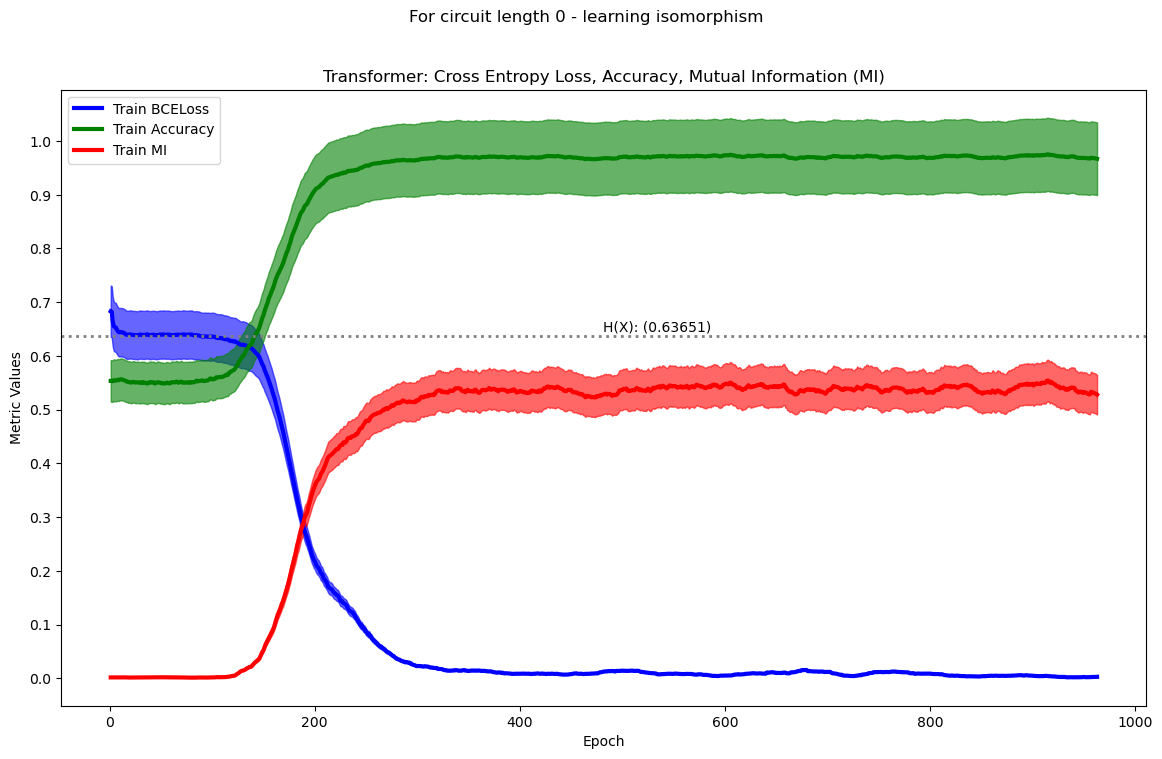

In [465]:
# Plotting Training and Validation
train_Loss_array = np.array(BCELoss_array)
train_BAcc_array = np.array(BAccuracy_array)
train_MI_array = np.array(MI_array)

window_size = 40
smoothed_train_BCELoss = np.convolve(train_Loss_array, np.ones(window_size)/window_size, mode='valid')
smoothed_train_BAcc = np.convolve(train_BAcc_array, np.ones(window_size)/window_size, mode='valid')
smoothed_train_MI = np.convolve(train_MI_array, np.ones(window_size)/window_size, mode='valid')

epochs = np.arange(1, len(smoothed_train_MI) + 1)

plt.style.use('default')
plt.figure(figsize=(14, 8))

margin = 0.07  # 5% margin for example
plt.plot(epochs, smoothed_train_BCELoss, color='blue', linestyle='-', linewidth=3, label='Train BCELoss')
upper_bound = smoothed_train_BCELoss * (1 + margin)
lower_bound = smoothed_train_BCELoss * (1 - margin)
plt.fill_between(epochs, lower_bound, upper_bound, color='blue', alpha=0.6)

plt.plot(epochs, smoothed_train_BAcc, color='green', linestyle='-', linewidth=3, label='Train Accuracy')
upper_bound = smoothed_train_BAcc * (1 + margin)
lower_bound = smoothed_train_BAcc * (1 - margin)
plt.fill_between(epochs, lower_bound, upper_bound, color='green', alpha=0.6)

plt.plot(epochs, smoothed_train_MI, color='red', linestyle='-', linewidth=3, label='Train MI')
upper_bound = smoothed_train_MI * (1 + margin)
lower_bound = smoothed_train_MI * (1 - margin)
plt.fill_between(epochs, lower_bound, upper_bound, color='red', alpha=0.6)

plt.axhline(y=upperBound, color='gray', linestyle=':', linewidth=2)
plt.text(len(epochs)/2, upperBound + 0.01, f'H(X): ({upperBound:,.5f})', color='black')

plt.title('Transformer: Cross Entropy Loss, Accuracy, Mutual Information (MI)', fontsize=12)
plt.suptitle('For circuit length 0 - learning isomorphism')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Metric Values', fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc='best', fontsize=10)
plt.show()

In [458]:
# Testing loop
model.eval()
total_loss = 0.0
predictions = []
given = []
actual = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs.long(), targets.long())
        loss = criterion(outputs, targets.float())
        total_loss += loss.item()

        for i in range(len(inputs)):
            predictions.append(outputs[i].tolist())
            given.append(inputs[i].tolist())
            actual.append(targets[i].tolist())

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

# Save the model and predictions
torch.save(model.state_dict(), 'quantum_transformer_model.pth')
preds = {
    'Initial_States': given,
    'Final_State_Pred': predictions,
    'Final_States': actual
}
final_df = pd.DataFrame(preds)
final_df.head()

NameError: name 'tqdm' is not defined